### Social Media Data Analysis Final Project

# "What do you all actually use ChatGPT for?": The use of ChatGPT among Reddit users

### Import requirements

In [1]:
! pip install vaderSentiment
! pip install transformers
! pip install torch
! pip install pandas

  Using cached tbb-2021.13.1-py3-none-win_amd64.whl.metadata (1.1 kB)
Using cached tbb-2021.13.1-py3-none-win_amd64.whl (286 kB)
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2


error: uninstall-distutils-installed-package

Cannot uninstall TBB 0.2

It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [2]:
import praw
import pandas as pd
from transformers import pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag
import string
from gensim.models import CoherenceModel
from collections import Counter
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from itertools import combinations
import numpy as np
import re
import pyLDAvis.gensim_models
from transformers import pipeline
from sklearn.metrics import accuracy_score

C:\Users\miric\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


### Data extraction using PRAW

In [3]:
# Reddit API credentials
'''
client_id = 'ZMofhnjTR26kdtmLwmYDsw'
client_secret = 'loJ5wR_7OWrXHdTlPmmSU5r7pbws1Q'
user_agent = 'your_user_agent'  # You can put any descriptive name here

# Initialize Reddit instance
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)

# List of subreddit post URLs
post_urls = [
    "https://www.reddit.com/r/ChatGPT/comments/133mc2v/what_do_you_all_actually_use_chatgpt_for/",
    "https://www.reddit.com/r/ChatGPT/comments/1cxw96y/what_do_you_guys_genuinely_use_chatgpt_for/",
    "https://www.reddit.com/r/ChatGPT/comments/179zagn/what_do_you_use_chatgpt_for/",
    "https://www.reddit.com/r/ChatGPT/comments/12stfb9/what_do_you_actually_use_chatgpt_for/",
    "https://www.reddit.com/r/ChatGPT/comments/11hlnyx/what_do_you_use_chatgpt_for/",
    "https://www.reddit.com/r/ChatGPT/comments/18fdupy/what_are_your_favorite_ways_to_use_chat_gpt/"
]

# Function to extract top-level comments
def extract_top_level_comments(post_url):
    submission = reddit.submission(url=post_url)
    submission.comments.replace_more(limit=None)
    comments = submission.comments  # This gives you only the top-level comments
    data = []
    for comment in comments:
        if isinstance(comment, praw.models.Comment):
            data.append({
                "username": comment.author.name if comment.author else "[deleted]",
                "comment": comment.body,
                "likes": comment.score
            })
    return data

# Extract data from all posts
all_top_level_comments = []
for url in post_urls:
    all_top_level_comments.extend(extract_top_level_comments(url))

# Convert to DataFrame
df = pd.DataFrame(all_top_level_comments)

# Save to CSV
df.to_csv('data/reddit_top_level_comments_21_08.csv', index=False)
'''

'\nclient_id = \'ZMofhnjTR26kdtmLwmYDsw\'\nclient_secret = \'loJ5wR_7OWrXHdTlPmmSU5r7pbws1Q\'\nuser_agent = \'your_user_agent\'  # You can put any descriptive name here\n\n# Initialize Reddit instance\nreddit = praw.Reddit(client_id=client_id,\n                     client_secret=client_secret,\n                     user_agent=user_agent)\n\n# List of subreddit post URLs\npost_urls = [\n    "https://www.reddit.com/r/ChatGPT/comments/133mc2v/what_do_you_all_actually_use_chatgpt_for/",\n    "https://www.reddit.com/r/ChatGPT/comments/1cxw96y/what_do_you_guys_genuinely_use_chatgpt_for/",\n    "https://www.reddit.com/r/ChatGPT/comments/179zagn/what_do_you_use_chatgpt_for/",\n    "https://www.reddit.com/r/ChatGPT/comments/12stfb9/what_do_you_actually_use_chatgpt_for/",\n    "https://www.reddit.com/r/ChatGPT/comments/11hlnyx/what_do_you_use_chatgpt_for/",\n    "https://www.reddit.com/r/ChatGPT/comments/18fdupy/what_are_your_favorite_ways_to_use_chat_gpt/"\n]\n\n# Function to extract top-level 

### Loading the data

In [4]:
# Reading the csv with only top-level comments
df_read_top_level = pd.read_csv('data/reddit_top_level_comments_21_08.csv')
display(df_read_top_level.head())
print("Number of top-level comments:", len(df_read_top_level))

# 1456 length with top-level comments

,username,comment,likes
0,hxstr,My wife and I used it to write a dispute lette...,374
1,East_Ad6086,We had an employee suffer a seizure at lunch i...,838
2,justlurking9891,Writing custom bedtime stories for my daughter...,490
3,[deleted],I used it to help me get a new job. Specifical...,141
4,whoops53,I used it last night to set up a spreadsheet f...,332


Number of top-level comments: 1456


### Cleaning the dataframe

In [5]:
# Remove rows where the username is [deleted]
df_read_top_level = df_read_top_level[df_read_top_level['username'] != '[deleted]']

# Remove rows where 'comment' is empty or NaN
df_read_top_level = df_read_top_level.dropna(subset=['comment'])

# Remove comments that are just empty strings (if any)
df_read_top_level = df_read_top_level[df_read_top_level['comment'].str.strip() != '']

# Remove comments from the user AutoModerator
df_read_top_level = df_read_top_level[df_read_top_level['username'] != 'AutoModerator']

print("Current number of comments", len(df_read_top_level))

Current number of comments 1362


### Descriptive statistics

In [6]:
# Calculate comment length in characters
df_read_top_level['comment_length_chars'] = df_read_top_level['comment'].apply(len)

# Calculate comment length in words
df_read_top_level['comment_length_words'] = df_read_top_level['comment'].apply(lambda x: len(x.split()))

# Calculate average comment length in characters
average_length_chars = df_read_top_level['comment_length_chars'].mean()

# Calculate average comment length in words
average_length_words = df_read_top_level['comment_length_words'].mean()

print("Average comment length in characters:", round(average_length_chars))
print("Average comment length in words:", round(average_length_words))
print()
print("Statistics for comment length in characters:", df_read_top_level['comment_length_chars'].describe())
print()
print("Statistics for comment length in words:", df_read_top_level['comment_length_words'].describe())
print()
print("Average comment like score:", df_read_top_level['likes'].mean())
print()
print("Statistics comment score:", df_read_top_level['likes'].describe())


Average comment length in characters: 277
Average comment length in words: 49

Statistics for comment length in characters: count    1362.000000
mean      276.604993
std       391.382117
min         1.000000
25%        66.000000
50%       152.500000
75%       327.500000
max      5631.000000
Name: comment_length_chars, dtype: float64

Statistics for comment length in words: count    1362.000000
mean       49.186490
std        68.538777
min         1.000000
25%        12.000000
50%        28.000000
75%        58.000000
max       936.000000
Name: comment_length_words, dtype: float64

Average comment like score: 6.002936857562408

Statistics comment score: count    1362.000000
mean        6.002937
std        35.935795
min        -6.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       838.000000
Name: likes, dtype: float64


In [7]:
# Creating new column for comment lenght
df_read_top_level['comment_length_words'] = df_read_top_level['comment'].apply(lambda x: len(x.split()))

# Identify the comment with the highest like number
highest_likes_comment = df_read_top_level.loc[df_read_top_level['likes'].idxmax()]

# Identify the comment with the highest word count
highest_word_count_comment = df_read_top_level.loc[df_read_top_level['comment_length_words'].idxmax()]

# Display the comments with the highest likes and highest word count
print("\nComment with the highest likes:")
print(f"Username: {highest_likes_comment['username']}")
print(f"Likes: {highest_likes_comment['likes']}")
print(f"Word Count: {highest_likes_comment['comment_length_words']}")
print(f"Comment: {highest_likes_comment['comment']}")

print("\nComment with the highest word count:")
print(f"Username: {highest_word_count_comment['username']}")
print(f"Likes: {highest_word_count_comment['likes']}")
print(f"Word Count: {highest_word_count_comment['comment_length_words']}")
print(f"Comment: {highest_word_count_comment['comment']}")


Comment with the highest likes:
Username: East_Ad6086
Likes: 838
Word Count: 97
Comment: We had an employee suffer a seizure at lunch in the the lunchroom and hit his head. While people were attending him I asked ChatGPT what we should do. It came back with 8-10 things, one of the things it stated was clearing a path for paramedics. So myself and others moved all the lunch tables to the outskirts of the room. When EMT came they were able to easily maneuver and get the person to the hospital. Again, since others were attending the individual I had time to do this. I thought it was very helpful.

Comment with the highest word count:
Username: FoxB1t3
Likes: 1
Word Count: 936
Comment: From what I saw in this topic my post gonna be quite different as you can get a bit more off... practical corporate implementation than building gym plan or stuff like that. 

First of all, just to context, I'm a sales director in a small company, I would say. We do about six million dollars of revenue and 

### Scatter plot for Like count and comment length

The value "1" appears 992 times in the "likes" column.


C:\Users\miric\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\miric\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\miric\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


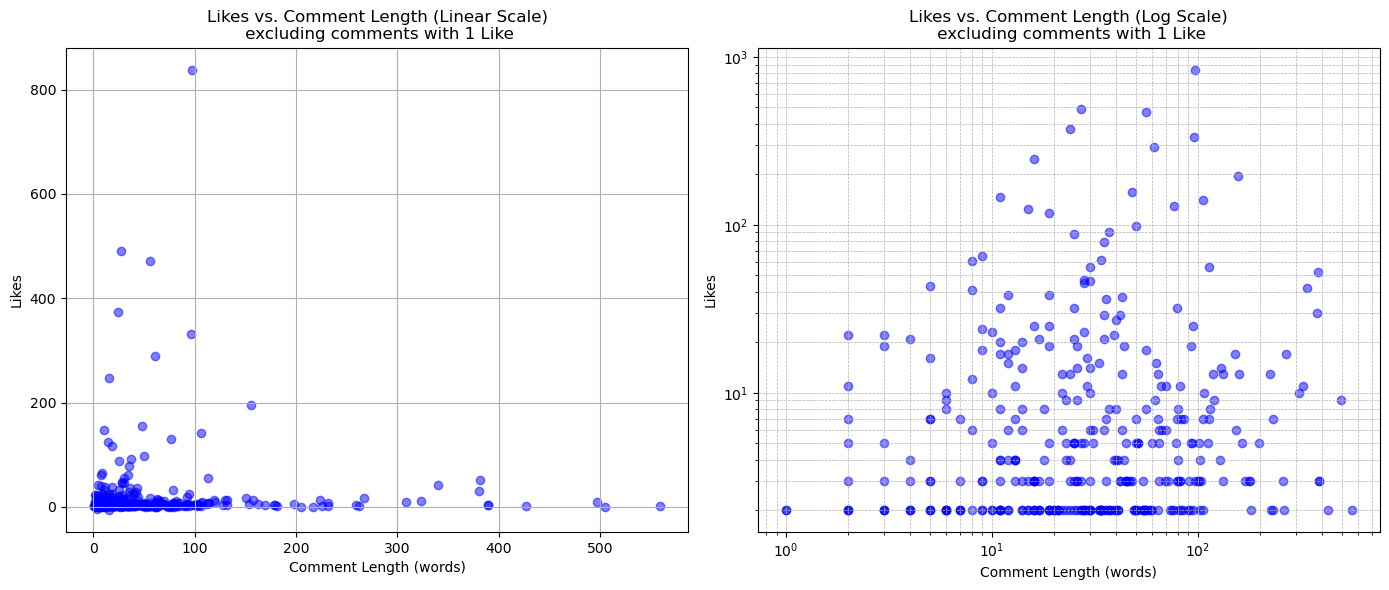

"\nX-Axis (Log Scale): Represents the length of comments in words. Since it's on a logarithmic scale, each tick mark on this \naxis represents a power of 10 (e.g., 10, 100, 1000 words).\n\nY-Axis (Log Scale): Represents the number of likes. Similar to the x-axis, each tick mark represents a power of 10 in the \nnumber of likes.\n"

In [8]:
# Checking how many comments have a 1 like
count_of_ones = df_read_top_level['likes'].value_counts().get(1, 0)
print(f'The value "1" appears {count_of_ones} times in the "likes" column.')

# Create a copy of the DataFrame excluding rows where "likes" is 1
df_filtered = df_read_top_level[df_read_top_level['likes'] != 1].copy()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot with regular (linear) scale
axs[0].scatter(df_filtered['comment_length_words'], df_filtered['likes'], alpha=0.5, color='blue')
axs[0].set_title('Likes vs. Comment Length (Linear Scale)\n excluding comments with 1 Like')
axs[0].set_xlabel('Comment Length (words)')
axs[0].set_ylabel('Likes')
axs[0].grid(True)

# Scatter plot with log scale
axs[1].scatter(df_filtered['comment_length_words'], df_filtered['likes'], alpha=0.5, color='blue')
axs[1].set_title('Likes vs. Comment Length (Log Scale)\n excluding comments with 1 Like')
axs[1].set_xlabel('Comment Length (words)')
axs[1].set_ylabel('Likes')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].grid(True, which="both", ls="--", linewidth=0.5)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

'''
X-Axis (Log Scale): Represents the length of comments in words. Since it's on a logarithmic scale, each tick mark on this 
axis represents a power of 10 (e.g., 10, 100, 1000 words).

Y-Axis (Log Scale): Represents the number of likes. Similar to the x-axis, each tick mark represents a power of 10 in the 
number of likes.
'''

### User engagement

In [9]:
# Count the number of comments per user
user_comment_counts = df_read_top_level['username'].value_counts()

# Calculate basic statistics for user engagement
user_engagement_stats = user_comment_counts.describe()

print("User engagement stats:", user_engagement_stats)
print("Comments per user", user_comment_counts.head(10))

User engagement stats: count    1328.000000
mean        1.025602
std         0.335233
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        12.000000
Name: count, dtype: float64
Comments per user username
yilun2               12
Difficult_Ad_3234     3
SteadfastEnd          3
allvys                3
cogniwerk             2
hunterlong12          2
gforty4u              2
AndreasE89            2
BorislavToshich       2
TheCleverCrumb        2
Name: count, dtype: int64


### Splitting comments with multiple paragraphs i.e. multiple ideas into separate comments
If comments have multiple unrelated ideas, separating them allows each idea to be analyzed individually, leading to more coherent topics.


In [10]:
# Function to split comments into multiple rows based on paragraph breaks
def split_paragraphs(row):
    paragraphs = row['comment'].split('\n\n')  # Split based on double newline (paragraph break)
    return pd.DataFrame({
        'username': [row['username']] * len(paragraphs),
        'comment': paragraphs
    })

# Apply the function and concatenate results
split_comments_df = pd.concat(df_read_top_level.apply(split_paragraphs, axis=1).to_list(), ignore_index=True)

# Print the resulting dataframe
display(split_comments_df)
print("Current number of comments:",len(split_comments_df))

,username,comment
0,hxstr,My wife and I used it to write a dispute lette...
1,East_Ad6086,We had an employee suffer a seizure at lunch i...
2,justlurking9891,Writing custom bedtime stories for my daughter...
3,whoops53,I used it last night to set up a spreadsheet f...
4,paulfrehley5,I ask it to speak to me like it is Captain Jea...
...,...,...
2292,MacKinnon911,At this point it has so many network time outs...
2293,Odd-Pineapple4992,Creating outlines for articles or suggesting m...
2294,MickeyF71,Creating Lego/Playmobil scenes from photos or ...
2295,LibrarianSmart2210,I like to ask prognoses and analyse about stoc...


Current number of comments: 2297


## Text normalization

In [11]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Define lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add custom stopwords
custom_stopwords = {"chatgpt", "chat", "gpt", "im", "use"}
stop_words.update(custom_stopwords)

# Function to expand contractions
def expand_contractions(text):
    contractions = {
        "don't": "do not",
        "can't": "cannot",
        "won't": "will not",
        "i'm": "i am",
        "it's": "it is",
        "that's": "that is",
        "there's": "there is",
        "wasn't": "was not",
        "weren't": "were not",
        "hasn't": "has not",
        "haven't": "have not",
        "hadn't": "had not",
        "shouldn't": "should not",
        "wouldn't": "would not",
        "couldn't": "could not",
        # Add more contractions if needed
    }
    for contraction, expansion in contractions.items():
        text = re.sub(r'\b{}\b'.format(contraction), expansion, text)
    return text

# Function to perform additional text normalization
def additional_normalize_text(text):
    # Expand contractions
    text = expand_contractions(text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply lemmatization
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words]
    
    return ' '.join(tokens)

# Apply the additional normalization function to the 'comment' column
split_comments_df['normalized_comment'] = split_comments_df['comment'].apply(additional_normalize_text)

# Print the first few rows to verify
display(split_comments_df.head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\miric\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,username,comment,normalized_comment
0,hxstr,My wife and I used it to write a dispute lette...,wife used write dispute letter parking ticket ...
1,East_Ad6086,We had an employee suffer a seizure at lunch i...,employee suffer seizure lunch lunchroom hit he...
2,justlurking9891,Writing custom bedtime stories for my daughter...,writing custom bedtime story daughter last nig...
3,whoops53,I used it last night to set up a spreadsheet f...,used last night set spreadsheet full healthy e...
4,paulfrehley5,I ask it to speak to me like it is Captain Jea...,ask speak like captain jean luc picard give pe...


### Most common words (including new stopwords) 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Most common words after adding new stopwords:
like: 320
work: 283
write: 275
also: 266
ask: 238
writing: 221
time: 217
used: 209
get: 204
code: 202
ive: 196
idea: 194
make: 184
using: 179
email: 173
google: 152
lot: 141
need: 132
give: 131
answer: 123


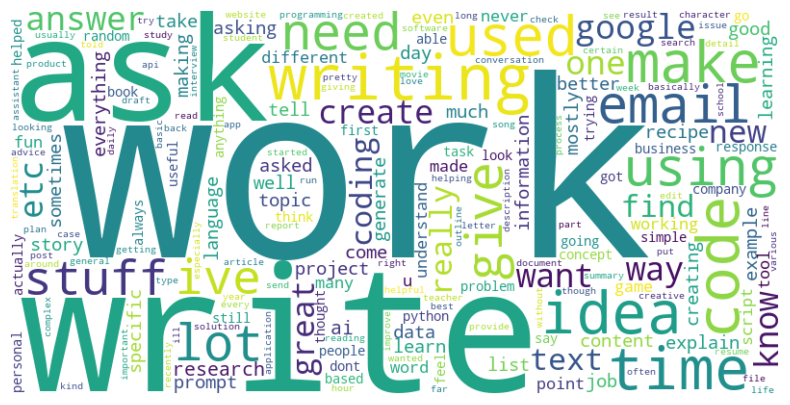

In [12]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ensure necessary NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')

# Define the stopwords
stop_words = set(stopwords.words('english'))

# Custom stopwords (as in your original code)
custom_stopwords = {"thing", "help", "question", "something"}
stop_words.update(custom_stopwords)

# Tokenize the normalized_comment column
split_comments_df['tokens'] = split_comments_df['normalized_comment'].apply(nltk.word_tokenize)

# Filter tokens to remove stopwords
split_comments_df['filtered_tokens'] = split_comments_df['tokens'].apply(
    lambda tokens: [word for word in tokens if word.lower() not in stop_words]
)

# Flatten the list of lists into a single list of words
all_words_filtered = [word for sublist in split_comments_df['filtered_tokens'] for word in sublist]

# Count word frequencies
word_counts_filtered = Counter(all_words_filtered)

# Get the most common words after updating stopwords
most_common_words_filtered = word_counts_filtered.most_common(20)

# Print the most common words after applying new stopwords
print("\nMost common words after adding new stopwords:")
for word, freq in most_common_words_filtered:
    print(f"{word}: {freq}")

# Join all filtered words into a single string
filtered_words_str = ' '.join(all_words_filtered)

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_words_str)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()


Takeaway so far is that world clouds arent giving the best overview, even when some words are manually filtered out

### Most common words, after adding new stopwords + excluding everything but nouns


Most common nouns after filtering:
work: 270
time: 217
idea: 194
code: 189
lot: 132
email: 122
way: 110
ask: 105
stuff: 103
google: 98
job: 95
story: 90
day: 84
research: 84
information: 78
data: 75
point: 74
language: 73
everything: 71
create: 69


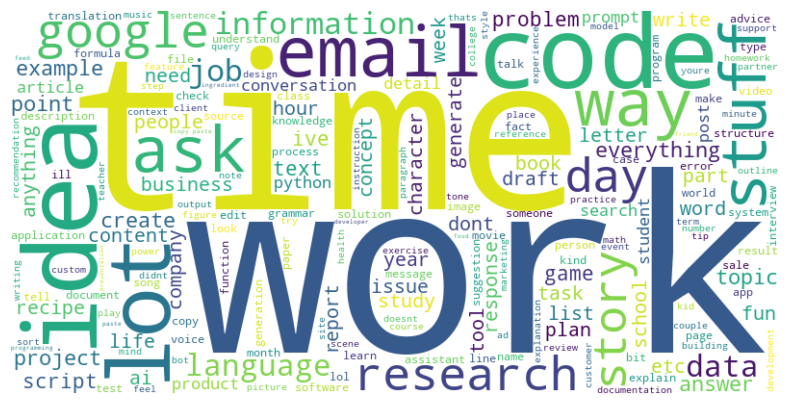

In [13]:
# Function to filter tokens to include only nouns
def filter_nouns(tokens):
    pos_tags = pos_tag(tokens)
    return [word for word, pos in pos_tags if pos.startswith('NN')]

# Apply filtering to keep only nouns
split_comments_df['noun_tokens'] = split_comments_df['tokens'].apply(filter_nouns)

# Flatten the list of lists into a single list of noun words
all_nouns = [word for sublist in split_comments_df['noun_tokens'] for word in sublist]

# Filter out stopwords from noun words
all_nouns_filtered = [word for word in all_nouns if word.lower() not in stop_words]

# Count noun frequencies
word_counts_filtered = Counter(all_nouns_filtered)

# Get the most common nouns after filtering
most_common_words_filtered = word_counts_filtered.most_common(20)

# Print the most common nouns
print("\nMost common nouns after filtering:")
for word, freq in most_common_words_filtered:
    print(f"{word}: {freq}")
    
# Join all filtered words into a single string
filtered_words_str = ' '.join(all_nouns_filtered)

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_words_str)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

split_comments_df.to_csv('data/reddit_normalized_data_tokens.csv', index=False)

Super interesting how "everything" and "anything" show up, worth mentioning.

### Sentiment analysis: VADER

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Ensure that VADER is available
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply sentiment analysis on the 'comment' column
split_comments_df['vader_sentiment_score'] = split_comments_df['comment'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Function to categorize sentiment
def categorize_sentiment(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create a sentiment label
split_comments_df['vader_sentiment_label'] = split_comments_df['vader_sentiment_score'].apply(categorize_sentiment)

# Display the first few rows to see the sentiment scores and labels
display(split_comments_df[['comment', 'vader_sentiment_score', 'vader_sentiment_label']].head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\miric\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,comment,vader_sentiment_score,vader_sentiment_label
0,My wife and I used it to write a dispute lette...,-0.4019,negative
1,We had an employee suffer a seizure at lunch i...,0.2484,positive
2,Writing custom bedtime stories for my daughter...,0.5719,positive
3,I used it last night to set up a spreadsheet f...,0.7424,positive
4,I ask it to speak to me like it is Captain Jea...,0.3612,positive


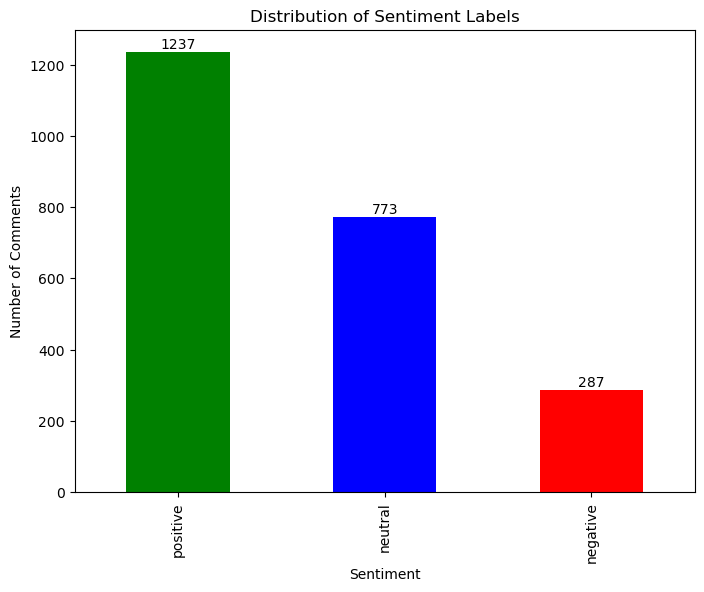

In [15]:
# Plot a histogram of the sentiment labels
plt.figure(figsize=(8, 6))
split_comments_df['vader_sentiment_label'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'])

# Add title and labels
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')

# Display the counts on top of the bars
for index, value in enumerate(split_comments_df['vader_sentiment_label'].value_counts()):
    plt.text(index, value, str(value), ha='center', va='bottom')

# Show the plot
plt.show()


### LDA: First attempt

In [16]:
# pip install scipy==1.12, in later versions a issue is raised: ImportError: cannot import name 'triu' from 'scipy.linalg'

In [18]:
# Tokenize comments
split_comments_df['tokens'] = split_comments_df['normalized_comment'].apply(lambda x: x.split())# change this, ie, add some stopwords: im, like

# Create a dictionary and corpus needed for LDA
dictionary = corpora.Dictionary(split_comments_df['tokens'])
corpus = [dictionary.doc2bow(text) for text in split_comments_df['tokens']]

# Perform LDA topic modeling
num_topics = 13 # Number of topics 
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=30)

# Print the topics
print("LDA Topics:")
for idx, topic in lda_model.print_topics(num_topics=num_topics):
    print(f'Topic: {idx} \nWords: {topic}\n')

LDA Topics:
Topic: 0 
Words: 0.019*"writing" + 0.018*"help" + 0.016*"idea" + 0.016*"research" + 0.012*"content" + 0.010*"ive" + 0.010*"also" + 0.009*"create" + 0.009*"question" + 0.009*"generate"

Topic: 1 
Words: 0.036*"thing" + 0.019*"get" + 0.017*"stuff" + 0.015*"learn" + 0.015*"new" + 0.013*"find" + 0.012*"would" + 0.010*"study" + 0.010*"learning" + 0.009*"help"

Topic: 2 
Words: 0.026*"like" + 0.016*"need" + 0.016*"help" + 0.015*"make" + 0.012*"story" + 0.011*"different" + 0.010*"needed" + 0.010*"idea" + 0.009*"day" + 0.009*"ive"

Topic: 3 
Words: 0.016*"stuff" + 0.014*"post" + 0.013*"used" + 0.013*"making" + 0.012*"article" + 0.011*"check" + 0.010*"point" + 0.010*"create" + 0.009*"instead" + 0.008*"script"

Topic: 4 
Words: 0.022*"used" + 0.016*"recipe" + 0.016*"coding" + 0.015*"time" + 0.014*"copy" + 0.014*"ive" + 0.012*"really" + 0.011*"email" + 0.009*"hour" + 0.009*"company"

Topic: 5 
Words: 0.016*"draft" + 0.015*"work" + 0.013*"write" + 0.012*"essay" + 0.012*"translation" + 

### LDA: Second attempt
#### Testing only using nouns, since there are many words that dont provide insight into the different uses(ask, always, stuff, theyre, help, etc) + adding some new stopwords that didn't get filtered out

In [19]:
# Ensure NLTK resources are downloaded
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\miric\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
# Updating stopwords
custom_stopwords = {"used", "using", "etc","stuff","ill","thats", "itll", "someone", "help", "everyone","didnt", "dont", "ive", "thing", "lol", "dd", "lot", "j", "get", "doesnt", "g", "chatgpts", "ask", "doesnt", "dont", "havent", "wont", "cant", "isnt", "shouldnt", "chat gpt"}
stop_words.update(custom_stopwords)

# Function to keep only nouns
def filter_nouns(text):
    words = word_tokenize(text)
    # Tag the words with their POS tags
    pos_tags = pos_tag(words)
    # Filter and keep only the nouns (NN, NNS, NNP, NNPS are typical tags for nouns)
    nouns = [word for word, pos in pos_tags if pos.startswith('NN') and word.lower() not in stop_words]
    return nouns

# Tokenize comments, filter out non-nouns, and remove stopwords
split_comments_df['tokens'] = split_comments_df['normalized_comment'].apply(filter_nouns)

# Create a dictionary and corpus needed for LDA
dictionary = corpora.Dictionary(split_comments_df['tokens'])
corpus = [dictionary.doc2bow(text) for text in split_comments_df['tokens']]

# Perform LDA topic modeling
num_topics = 20  # Number of topics to extract
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20)

# Print the topics
print("LDA Topics:")
for idx, topic in lda_model.print_topics(num_topics=num_topics):
    print(f'Topic: {idx} \nWords: {topic}\n')

# Save the model and dictionary
#lda_model.save('lda_model.gensim')
#dictionary.save('dictionary.gensim')

###################################################################################################################################
# Scores

# Compute Coherence Scores
coherence_model_lda = CoherenceModel(model=lda_model, texts=split_comments_df['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')

coherence_model_umass = CoherenceModel(model=lda_model, texts=split_comments_df['tokens'], dictionary=dictionary, coherence='u_mass')
coherence_umass = coherence_model_umass.get_coherence()
print(f'u_mass Coherence Score: {coherence_umass}')

coherence_model_npmi = CoherenceModel(model=lda_model, texts=split_comments_df['tokens'], dictionary=dictionary, coherence='c_npmi')
coherence_npmi = coherence_model_npmi.get_coherence()
print(f'c_npmi Coherence Score: {coherence_npmi}')

perplexity = lda_model.log_perplexity(corpus)
print(f'Perplexity: {perplexity}')

def jaccard_similarity(topic1, topic2):
    intersection = len(set(topic1).intersection(set(topic2)))
    union = len(set(topic1).union(set(topic2)))
    return intersection / union

def calculate_jaccard_diversity(lda_model, top_n_words=10):
    topics = lda_model.show_topics(formatted=False, num_words=top_n_words)
    topic_words = [[word for word, _ in topic[1]] for topic in topics]
    
    diversities = []
    for topic_pair in combinations(topic_words, 2):
        diversities.append(1 - jaccard_similarity(*topic_pair))
    
    return np.mean(diversities)

jaccard_diversity = calculate_jaccard_diversity(lda_model, top_n_words=10)
print(f"Average Jaccard Diversity: {jaccard_diversity:.4f}")


def calculate_exclusivity(lda_model, top_n_words=10):
    topics = lda_model.show_topics(formatted=False, num_words=top_n_words)
    word_frequencies = {}

    for topic_id, topic_words in topics:
        for word, prob in topic_words:
            if word not in word_frequencies:
                word_frequencies[word] = []
            word_frequencies[word].append(prob)
    
    exclusivities = []
    for word, freqs in word_frequencies.items():
        freqs = np.array(freqs)
        exclusivity = np.max(freqs) / np.sum(freqs)
        exclusivities.append(exclusivity)
    
    return np.mean(exclusivities)

exclusivity_score = calculate_exclusivity(lda_model, top_n_words=10)
print(f"Average Topic Exclusivity: {exclusivity_score:.4f}")

LDA Topics:
Topic: 0 
Words: 0.100*"email" + 0.080*"work" + 0.037*"text" + 0.025*"script" + 0.025*"point" + 0.025*"week" + 0.024*"python" + 0.023*"test" + 0.018*"course" + 0.018*"company"

Topic: 1 
Words: 0.034*"work" + 0.034*"idea" + 0.033*"need" + 0.025*"business" + 0.021*"hour" + 0.020*"recipe" + 0.020*"create" + 0.020*"understand" + 0.019*"research" + 0.018*"learn"

Topic: 2 
Words: 0.042*"assistant" + 0.041*"math" + 0.030*"development" + 0.027*"software" + 0.026*"topic" + 0.026*"assistance" + 0.025*"talk" + 0.020*"generate" + 0.020*"list" + 0.017*"companion"

Topic: 3 
Words: 0.039*"concept" + 0.038*"prompt" + 0.035*"kind" + 0.030*"student" + 0.030*"approach" + 0.027*"trouble" + 0.023*"bot" + 0.022*"part" + 0.020*"learn" + 0.018*"strategy"

Topic: 4 
Words: 0.043*"school" + 0.035*"time" + 0.029*"way" + 0.024*"planning" + 0.023*"building" + 0.023*"tool" + 0.022*"knowledge" + 0.020*"power" + 0.020*"consciousness" + 0.018*"trip"

Topic: 5 
Words: 0.031*"game" + 0.031*"example" + 0.0

#### Underfitting: 
If the number of topics is too small for the complexity of your data, LDA might try to force unrelated concepts into the same topic. This can result in topics that seem incoherent, with words that don't logically fit together.
#### Overfitting: 
Conversely, if there are too many topics, LDA might create topics that mix unrelated concepts because it struggles to find distinct patterns in the data.

### General Guidelines for Coherence Scores:
#### High Coherence Score (~0.6 or above): 
This generally indicates that the topics are well-formed and the words within each topic are closely related, making them more interpretable.
##### Moderate Coherence Score (0.4 - 0.6): 
A score in this range suggests that the topics are somewhat coherent but might still include some loosely related words. The topics may be interpretable but could benefit from further tuning.
#### Low Coherence Score (<0.4): 
Typically indicates that the topics are not well-formed and the words within topics may not be closely related. The topics might be less interpretable and may require significant adjustments, such as changing the number of topics, improving preprocessing, or modifying the LDA parameters.

### Checking for the ideal topic number for the best coherence score

Number of Topics: 10, Coherence Score: 0.3783
Number of Topics: 15, Coherence Score: 0.4123
Number of Topics: 20, Coherence Score: 0.4483
Number of Topics: 25, Coherence Score: 0.4724
Number of Topics: 30, Coherence Score: 0.4807
Number of Topics: 35, Coherence Score: 0.4882
Number of Topics: 40, Coherence Score: 0.4915
Number of Topics: 45, Coherence Score: 0.4919
Number of Topics: 50, Coherence Score: 0.4686
Number of Topics: 55, Coherence Score: 0.5049
Number of Topics: 60, Coherence Score: 0.4936
Number of Topics: 65, Coherence Score: 0.4814
Number of Topics: 70, Coherence Score: 0.4716


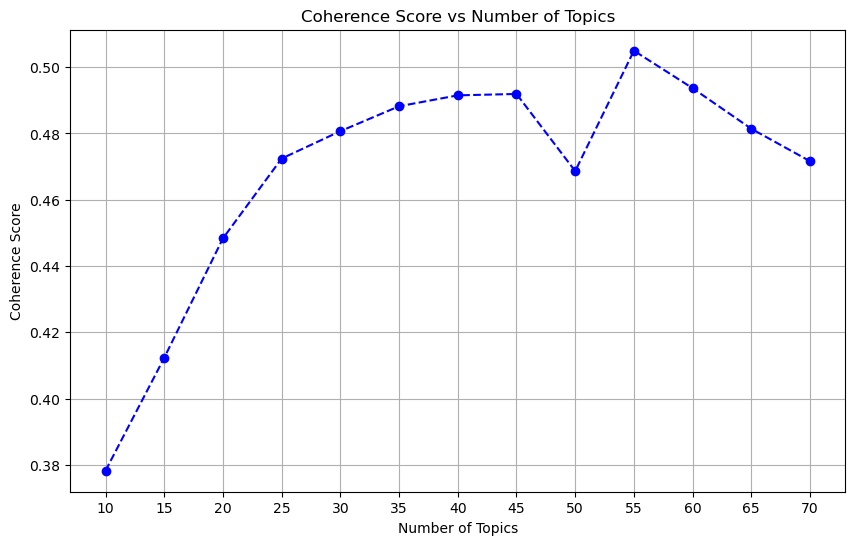

The optimal number of topics is: 55 with a coherence score of 0.5049


'\nNumber of Topics: 10, Coherence Score: 0.4011\nNumber of Topics: 15, Coherence Score: 0.4256\nNumber of Topics: 20, Coherence Score: 0.4531\nNumber of Topics: 25, Coherence Score: 0.4600\nNumber of Topics: 30, Coherence Score: 0.4910\nNumber of Topics: 35, Coherence Score: 0.4822\nNumber of Topics: 40, Coherence Score: 0.4839\nNumber of Topics: 45, Coherence Score: 0.4872\nNumber of Topics: 50, Coherence Score: 0.4953\nNumber of Topics: 55, Coherence Score: 0.5096\nNumber of Topics: 60, Coherence Score: 0.5056\nNumber of Topics: 65, Coherence Score: 0.4860\nNumber of Topics: 70, Coherence Score: 0.4865\n'

In [21]:
# Testing topic coherence between 10 and 70 topics, with a step of 5
topic_range = range(10,75, 5) 
passes = 20
coherence_scores = []

# Iterate over each number of topics
for num_topics in topic_range:
    # Train the LDA model
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)
    
    # Calculate the coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=split_comments_df['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)
    
    print(f'Number of Topics: {num_topics}, Coherence Score: {coherence_lda:.4f}')

# Plot the coherence scores
plt.figure(figsize=(10, 6))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='--', color='b')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(topic_range)
plt.grid(True)
plt.show()

# Find the number of topics with the best coherence score
optimal_num_topics = topic_range[coherence_scores.index(max(coherence_scores))]
print(f'The optimal number of topics is: {optimal_num_topics} with a coherence score of {max(coherence_scores):.4f}')

'''
Number of Topics: 10, Coherence Score: 0.4011
Number of Topics: 15, Coherence Score: 0.4256
Number of Topics: 20, Coherence Score: 0.4531
Number of Topics: 25, Coherence Score: 0.4600
Number of Topics: 30, Coherence Score: 0.4910
Number of Topics: 35, Coherence Score: 0.4822
Number of Topics: 40, Coherence Score: 0.4839
Number of Topics: 45, Coherence Score: 0.4872
Number of Topics: 50, Coherence Score: 0.4953
Number of Topics: 55, Coherence Score: 0.5096
Number of Topics: 60, Coherence Score: 0.5056
Number of Topics: 65, Coherence Score: 0.4860
Number of Topics: 70, Coherence Score: 0.4865
'''

### LDA with best performing topic number (i.e. number that achieved the highest coherence score): 55

In [22]:
# Define the number of topics
num_topics = 55  # Updated to 55 topics

# Perform LDA topic modeling with 55 topics
lda_model_55_topics = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20)

# Print the topics
print("LDA Topics with 55 Topics:")
for idx, topic in lda_model_55_topics.print_topics(num_topics=num_topics):
    print(f'Topic: {idx} \nWords: {topic}\n')

# Compute Coherence Scores for the new model
coherence_model_lda_55 = CoherenceModel(model=lda_model_55_topics, texts=split_comments_df['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda_55 = coherence_model_lda_55.get_coherence()
print(f'Coherence Score for 55 Topics: {coherence_lda_55}')

coherence_model_umass_55 = CoherenceModel(model=lda_model_55_topics, texts=split_comments_df['tokens'], dictionary=dictionary, coherence='u_mass')
coherence_umass_55 = coherence_model_umass_55.get_coherence()
print(f'u_mass Coherence Score for 55 Topics: {coherence_umass_55}')

coherence_model_npmi_55 = CoherenceModel(model=lda_model_55_topics, texts=split_comments_df['tokens'], dictionary=dictionary, coherence='c_npmi')
coherence_npmi_55 = coherence_model_npmi_55.get_coherence()
print(f'c_npmi Coherence Score for 55 Topics: {coherence_npmi_55}')

perplexity_55 = lda_model_55_topics.log_perplexity(corpus)
print(f'Perplexity for 55 Topics: {perplexity_55}')

# Calculate Jaccard Diversity for the new model
jaccard_diversity_55 = calculate_jaccard_diversity(lda_model_55_topics, top_n_words=10)
print(f"Average Jaccard Diversity for 55 Topics: {jaccard_diversity_55:.4f}")

# Calculate Topic Exclusivity for the new model
exclusivity_score_55 = calculate_exclusivity(lda_model_55_topics, top_n_words=10)
print(f"Average Topic Exclusivity for 55 Topics: {exclusivity_score_55:.4f}")


LDA Topics with 55 Topics:
Topic: 0 
Words: 0.117*"way" + 0.042*"point" + 0.040*"writing" + 0.038*"let" + 0.034*"solve" + 0.032*"power" + 0.028*"build" + 0.028*"min" + 0.025*"starter" + 0.023*"partner"

Topic: 1 
Words: 0.293*"code" + 0.058*"time" + 0.045*"friend" + 0.043*"generation" + 0.036*"place" + 0.032*"sort" + 0.031*"coherent" + 0.025*"location" + 0.023*"map" + 0.021*"sheet"

Topic: 2 
Words: 0.145*"check" + 0.096*"test" + 0.076*"figure" + 0.072*"step" + 0.053*"money" + 0.041*"curiosity" + 0.034*"week" + 0.028*"information" + 0.020*"breeze" + 0.018*"time"

Topic: 3 
Words: 0.049*"trip" + 0.049*"area" + 0.046*"planning" + 0.043*"road" + 0.041*"element" + 0.038*"possibility" + 0.036*"human" + 0.030*"plant" + 0.029*"hour" + 0.027*"sql"

Topic: 4 
Words: 0.169*"tool" + 0.108*"hour" + 0.074*"lesson" + 0.052*"car" + 0.041*"time" + 0.032*"plan" + 0.026*"engine" + 0.023*"box" + 0.023*"explore" + 0.023*"search"

Topic: 5 
Words: 0.108*"movie" + 0.093*"minute" + 0.074*"review" + 0.051*"li

### Checking if passes number significantly change the coherence score

In [23]:
'''
It printed number of topics but the results actually display the number of passes, with 45 topics.
Takeaway is the number of passes doesnt affect significantlz this coherence score...

Num Passes: 20, Coherence Score: 0.4711171527357455
Num Passes: 21, Coherence Score: 0.48179460097997673
Num Passes: 22, Coherence Score: 0.47208902089842975
Num Passes: 23, Coherence Score: 0.48370155596974396
Num Passes: 24, Coherence Score: 0.49041083631262
Num Passes: 25, Coherence Score: 0.48081689643583936
Num Passes: 26, Coherence Score: 0.4914062904222933
Num Passes: 27, Coherence Score: 0.4919089566701237
Num Passes: 28, Coherence Score: 0.48233641763023627
Num Passes: 29, Coherence Score: 0.4870474862849878
Num Passes: 30, Coherence Score: 0.48036428443782203
Num Passes: 31, Coherence Score: 0.4892981583142678
Num Passes: 32, Coherence Score: 0.4940203930760308
Num Passes: 33, Coherence Score: 0.4929069318577876
Num Passes: 34, Coherence Score: 0.47236354174373474
Num Passes: 35, Coherence Score: 0.4931495901882934
Num Passes: 36, Coherence Score: 0.48068070657895995
Num Passes: 37, Coherence Score: 0.4725457917377161
Num Passes: 38, Coherence Score: 0.4874961619987124
Num Passes: 39, Coherence Score: 0.49384857801052007
Num Passes: 40, Coherence Score: 0.4963436148049242
Num Passes: 41, Coherence Score: 0.48620236886516527
Num Passes: 42, Coherence Score: 0.4675542825678025
Num Passes: 43, Coherence Score: 0.4732459380453013
Num Passes: 44, Coherence Score: 0.4592586439179933
Num Passes: 45, Coherence Score: 0.48186877725218047
Num Passes: 46, Coherence Score: 0.49563680853284553
Num Passes: 47, Coherence Score: 0.49117888015041833
Num Passes: 48, Coherence Score: 0.4657836876324582
Num Passes: 49, Coherence Score: 0.4926213973594111
Best Num Passes: 40 with Coherence Score: 0.4963436148049242
'''

'\nIt printed number of topics but the results actually display the number of passes, with 45 topics.\nTakeaway is the number of passes doesnt affect significantlz this coherence score...\n\nNum Passes: 20, Coherence Score: 0.4711171527357455\nNum Passes: 21, Coherence Score: 0.48179460097997673\nNum Passes: 22, Coherence Score: 0.47208902089842975\nNum Passes: 23, Coherence Score: 0.48370155596974396\nNum Passes: 24, Coherence Score: 0.49041083631262\nNum Passes: 25, Coherence Score: 0.48081689643583936\nNum Passes: 26, Coherence Score: 0.4914062904222933\nNum Passes: 27, Coherence Score: 0.4919089566701237\nNum Passes: 28, Coherence Score: 0.48233641763023627\nNum Passes: 29, Coherence Score: 0.4870474862849878\nNum Passes: 30, Coherence Score: 0.48036428443782203\nNum Passes: 31, Coherence Score: 0.4892981583142678\nNum Passes: 32, Coherence Score: 0.4940203930760308\nNum Passes: 33, Coherence Score: 0.4929069318577876\nNum Passes: 34, Coherence Score: 0.47236354174373474\nNum Passe

### Topic comparison to already existing categories in prompt databases

#### 1. chatgptpromptshub
Act as for ChatGPT
All ChatGPT Plugins
Amazing Prompts
Analytics
Art and Design
Business Startups
Career Development
ChatGPT for Coding
ChatGPT Plugins
Customer Service
Cooking
E-commerce
Education
Environment and Sustainability
Fashion
Financial Services
Gaming
Health and Fitness
Home Improvement
Innovation
Legal Advice
Movies and Entertainment
Music
Parenting
Personal Development
Politics
Relationships
Sports
Teaching
Technology
Travel Planning
Web Content

#### 2. thepromptindex 
Filters:
    
All 
Act as
Misc
Business
Education
Fun
Personal
Marketing
AI
Image
Coding